# Solution:  Solving the Advection Equation in 1-D

Harald Pfeiffer (Albert-Einstein-Institute)

Prepared for the ICTS Summer School on Gravitational Waves 2020, Updated for IMPRS Course Computational Physics @ AEI, 2025.


Demonstrate numerical solutions of the 1D advection problem on the interval 0<=x<=1 with periodic boundary conditions:
  partial u/partial t - partial u/partial x = 0,   u(x=0, t) = u(x=1, t)

Utilize a variety of spatial discretization methods:
    - Finite differences
    - Pseudo-spectral collocation
    - Discontinuous Galerkin
Employ method of lines with several different time-steppers:
    - Forward-Euler
    - Runge-Kutta 2
    - Runge-Kutta 4

In [1]:
import sys
import os
import math
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib 
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
import collections
print(sys.version)

3.11.3 (main, Apr  7 2023, 20:13:31) [Clang 14.0.0 (clang-1400.0.29.202)]


# Generalities

In [2]:
# solution to be recovered
def AnalyticSolution(x,t):
    return np.exp(-2*np.cos(2*np.pi*(x-t)))

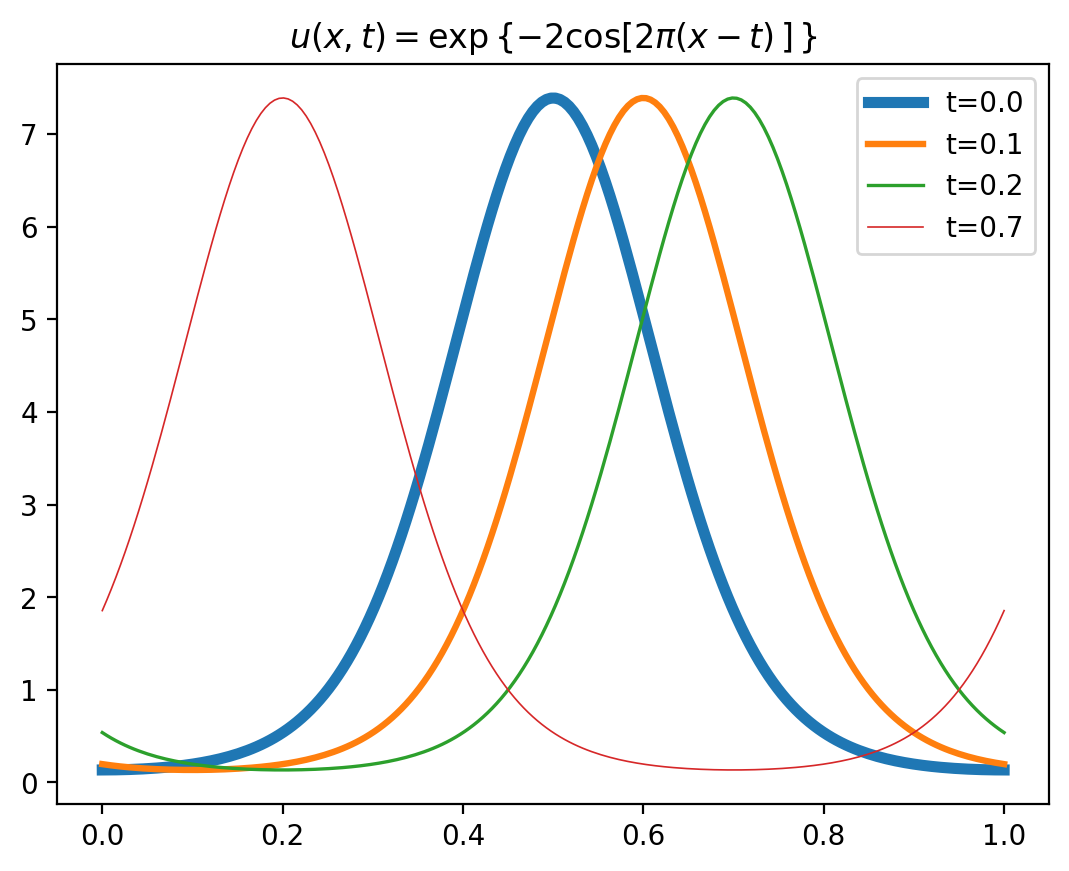

In [3]:
x=np.linspace(0.,1., 200)
plt.plot(x,AnalyticSolution(x, 0), label='t=0.0',lw=4)
plt.plot(x,AnalyticSolution(x, 0.1), label='t=0.1',lw=2.3)
plt.plot(x,AnalyticSolution(x, 0.2), label='t=0.2',lw=1.2)
plt.plot(x,AnalyticSolution(x, 0.7), label='t=0.7',lw=0.6)

plt.title("$u(x,t) = \exp\{ -2\cos[2\pi(x-t)\,]\,\}$")
plt.legend();

# Time-steppers

The *_Step functions evolve for one time-step.  Moved ahead in this notebook, since they apply to both finite-differences and Spectral methods. 

In [4]:
# === Task FD-2 ===
def ForwardEuler_Step(t, u, F, dt, info):
    """Perform one Forward Euler step
       - t current time
       - u current solution
       - F function that computes the right-hand-side 'F' in 
            du/dt = F,
         with calling sequence F(t, u, info)
       - dt time-step
       - info extra information needed by the right-hand-side function 
         (e.g. mass-matrices for DG)
    returns
       t_new, u_new
       """
    u_new = u + dt*F(t, u, info)
    return t+dt, u_new

In [5]:
def RK2_Step(t, u, F, dt, info):
    """"Perform one Runge-Kutta 2 step
       - t current time
       - u current solution
       - F function that computes the right-hand-side 'F' in 
            du/dt = F
         The calling sequence is F(t, u, info)
       - dt time-step
       - info extra information needed by the right-hand-side function 
         (e.g. mass-matrices for DG)
    returns
       t_new, u_new
    """

    k1=dt*F(t, u, info)
    k2=dt*F(t+0.5*dt, u+0.5*k1, info)
    return (t+dt, u+k2)

In [6]:
def RK4_Step(t, u, F, dt, info):
    """"Perform one Runge-Kutta 4 step
       - t current time
       - u current solution
       - F function that computes the right-hand-side 'F' in 
            du/dt = F
         The calling sequence is F(t, u, info)
       - dt time-step
       - info extra information needed by the right-hand-side function 
         (e.g. mass-matrices for DG)
    returns
       t_new, u_new
    """
    
    k1=dt*F(t, u, info)
    k2=dt*F(t+0.5*dt, u+0.5*k1, info)
    k3=dt*F(t+0.5*dt, u+0.5*k2, info)
    k4=dt*F(t+dt, u+k3, info)
    return (t+dt, u+k1/6.+k2/3.+k3/3.+k4/6.)

In [7]:
# === Task FD-3 ===
def Evolve(t, t_final, u, F, Tstepper, CF, info):
    """Evolve the evolution equations represented by right-hand-side 'F'
    with time-stepper Tstepper until final time 't_final'.  
      - t current time
      - t_final final time
      - u solution at current time 't'
      - F right-hand-side of evolution equations, w/ calling sequence F(t, u, info)
      - Tstepper time-stepper with calling sequence Tstepper(t, u, F, dt, info)
      - CF courant-factor, i.e dt will be chosen such that dt < C dxmin
      - info class holding any additional information necessary.  It is passed into 'rhs'.
        It is also assumed that info.dxmin returns the minimal grid-spacing.
    returns
      t_final, u_final"""
    
    # time-step
    dt = CF*info.dxmin
    Nsteps=math.ceil((t_final-t)/dt)  # round up number of steps
    dt = (t_final-t)/Nsteps           # adjust dt to precisely reach t_final
    for i in range(Nsteps):
        t, u = Tstepper(t, u, F, dt, info)
    return t, u

# Finite-differences

In [8]:
# === TASK FD-1 ===
def dudx(u):
    """Given data u at uniformly spaced grid-points [0, 1[, 
    compute its spatial derivative with centered finite-differencing.
    This routine assumes periodic boundary conditions"""
    du=u.copy()
    du[0]=u[1]-u[-1]
    du[1:-1]=u[2:]-u[:-2]
    du[-1]=u[0]-u[-2]
    du *= len(u)/2.    # divide by 2h  <-->  multiply by N/2, since h=1/N.   
    return du

def RHS_FD(t, u, info):
    """Computes the right-hand-side F(t,u) of the advection equation 
       partial_t u = F(t,u)
    with 2-nd order finite-differences.  Here u is the vector of data 
    with one value per grid-point.  We assume a domain x\in [0,1[, 
    and use centered differences with periodic boundary conditions."""
    return -dudx(u)

In [9]:
def Setup_FD(N):
    """Perform the necessary setup for a finite-difference 
    evolution on 'N' grid-points. 

    returns 
        t, u, info
    where
      - t=0.0  the initial time
      - u the solution at t=0 (i.e. the initial data)
      - info a tuple containing
         - info.dxmin minimal grid-spacing
         - info.x an array of grid-points"""

    # storage for extra info
    FD_Info_t=collections.namedtuple('FD_Info_t', 'dxmin, x')
    x = np.linspace(0., 1., N, endpoint=False)
    info=FD_Info_t(dxmin=1./N, x=x)
    u = AnalyticSolution(x, 0.)
    return 0., u, info

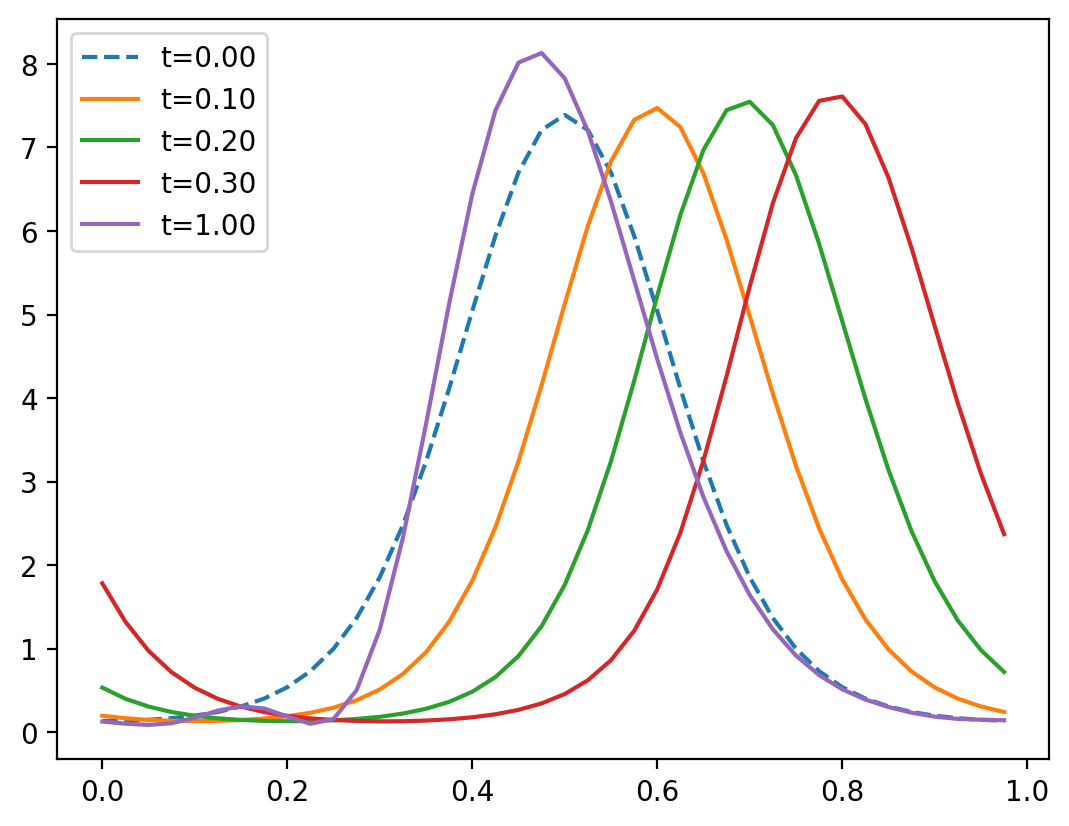

In [10]:
t, u, info = Setup_FD(40)
plt.plot(info.x,u, '--', label='t={:4.2f}'.format(t))
for t_final in [0.1, 0.2, 0.3, 1.]:
    t,u=Evolve(t, t_final, u, RHS_FD, ForwardEuler_Step, 1/2**3, info)
    plt.plot(info.x,u, label='t={:4.2f}'.format(t))
plt.legend();

N=20
N=40
N=80
N=160
N=320
N=640


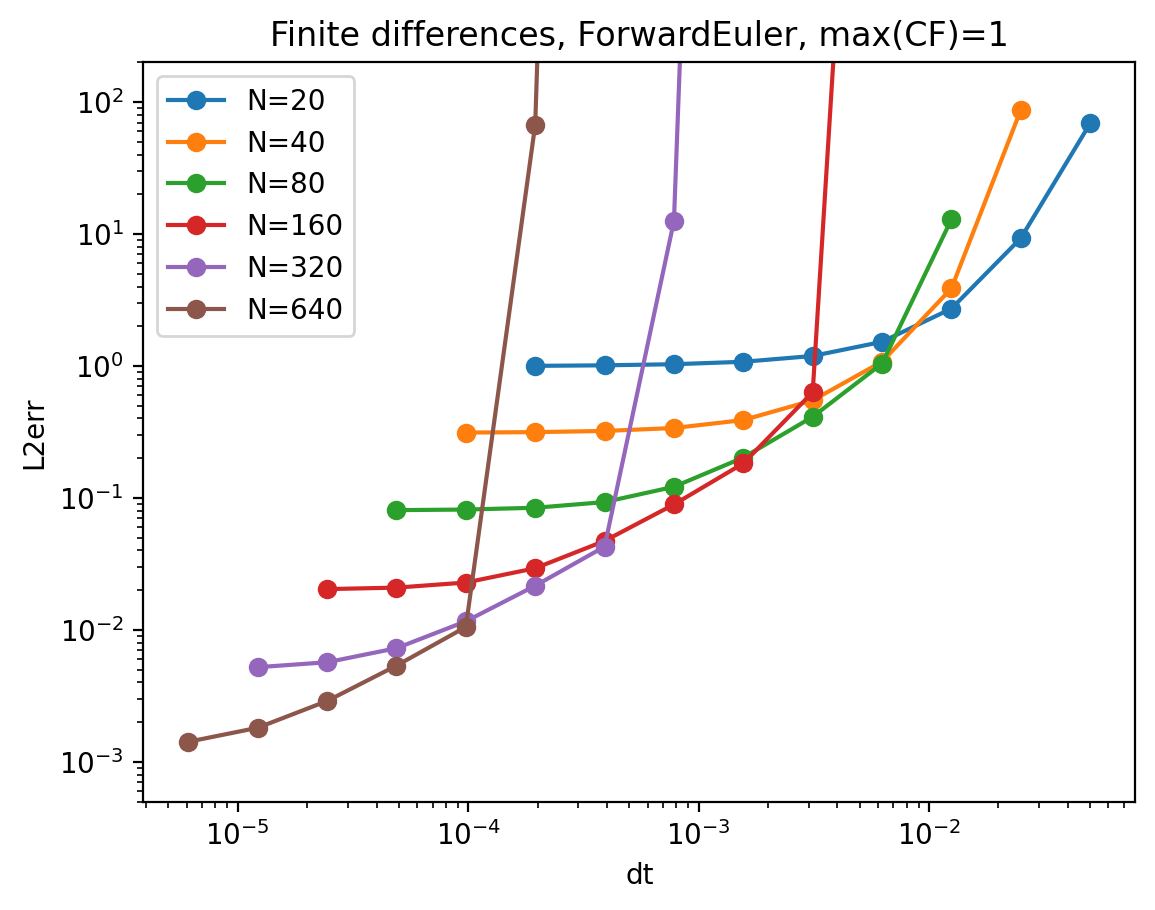

In [11]:
# convergence test - ForwardEuler
#
# note instability for sufficiently long evolutions, even at small CF
# FE with central differences is unconditionally unstable
Tfinal=1.
errN={}  # error at fixed N  vs. CF
for N in [20, 40, 80, 160, 320, 640]:
    print("N={}".format(N))
    errN[N]=[[], []]
    for CF in [1., 1./2, 1/2**2, 1/2**3, 1/2**4, 1/2**5, 1/2**6, 1/2**7, 1/2**8]:
        t, u0, info = Setup_FD(N)
        t,u=Evolve(t, Tfinal, u0, RHS_FD, ForwardEuler_Step, CF, info)
        # L2-norm of error after advecting once through domain
        err=np.sqrt(np.dot(u-u0, u-u0)/N)
        errN[N][0].append(CF*info.dxmin)  # store time-step
        errN[N][1].append(err)            # store error
    plt.loglog(errN[N][0], errN[N][1], 'o-', label="N={}".format(N) # , basey=2., basex=10
               )  # plot!
plt.xlabel('dt'); plt.ylabel('L2err'); plt.title("Finite differences, ForwardEuler, max(CF)=1")
plt.legend()
plt.ylim(5e-4, 2e2);

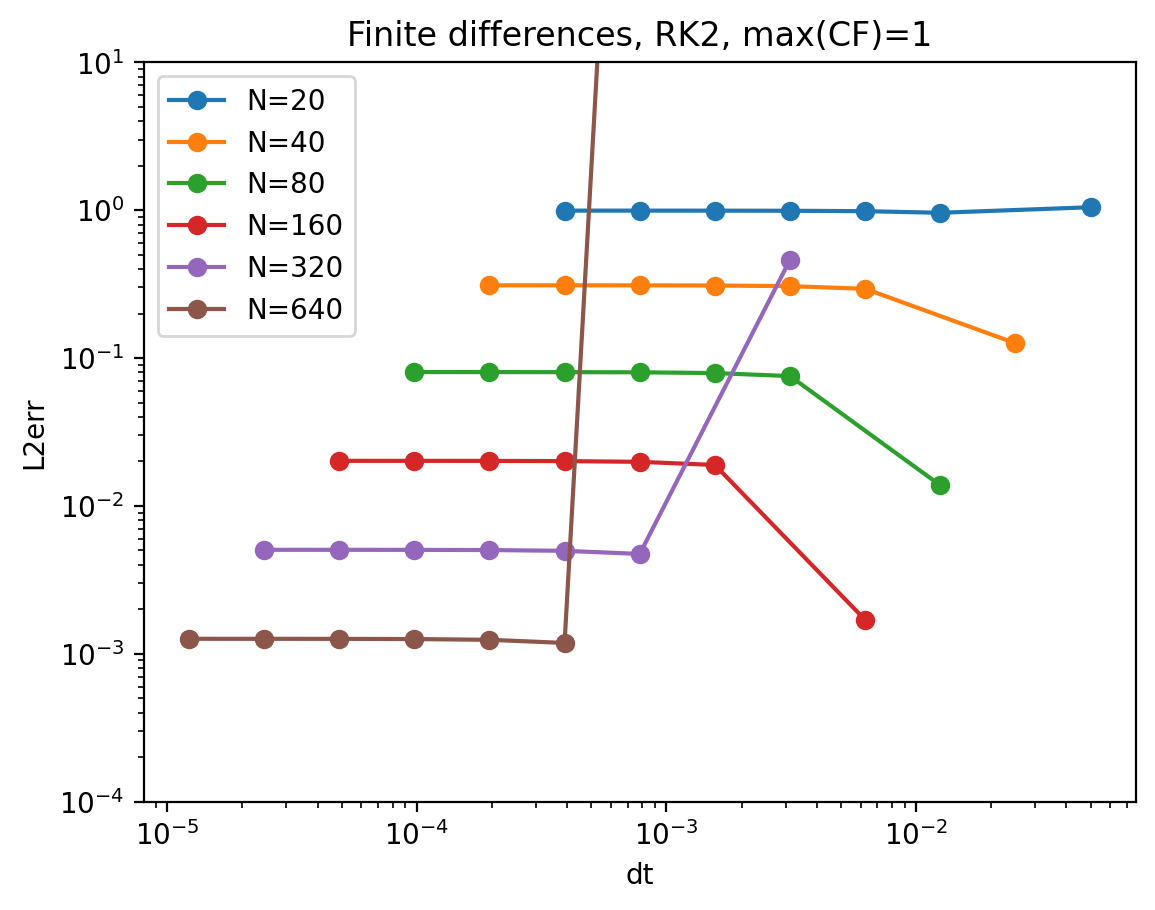

In [12]:
# convergence test - RK2
Tfinal=1.
errN={}  # error at fixed N  vs. CF
for N in [20, 40, 80, 160, 320, 640]:
    errN[N]=[[], []]
    for CF in [1/2**0, 1/2**2, 1/2**3, 1/2**4, 1/2**5, 1/2**6, 1/2**7]:
        t, u0, info = Setup_FD(N)
        t,u=Evolve(t, Tfinal, u0, RHS_FD, RK2_Step, CF, info)
        # L2-norm of error after advecting once through domain
        err=np.sqrt(np.dot(u-u0, u-u0)/N)
        errN[N][0].append(CF*info.dxmin)  # store time-step
        errN[N][1].append(err)            # store error
    plt.loglog(errN[N][0], errN[N][1], 'o-', label="N={}".format(N) # ,basey=2., basex=10
               )  # plot!
plt.xlabel('dt'); plt.ylabel('L2err'); plt.title("Finite differences, RK2, max(CF)=1")
plt.legend()
plt.ylim(1e-4, 10.);

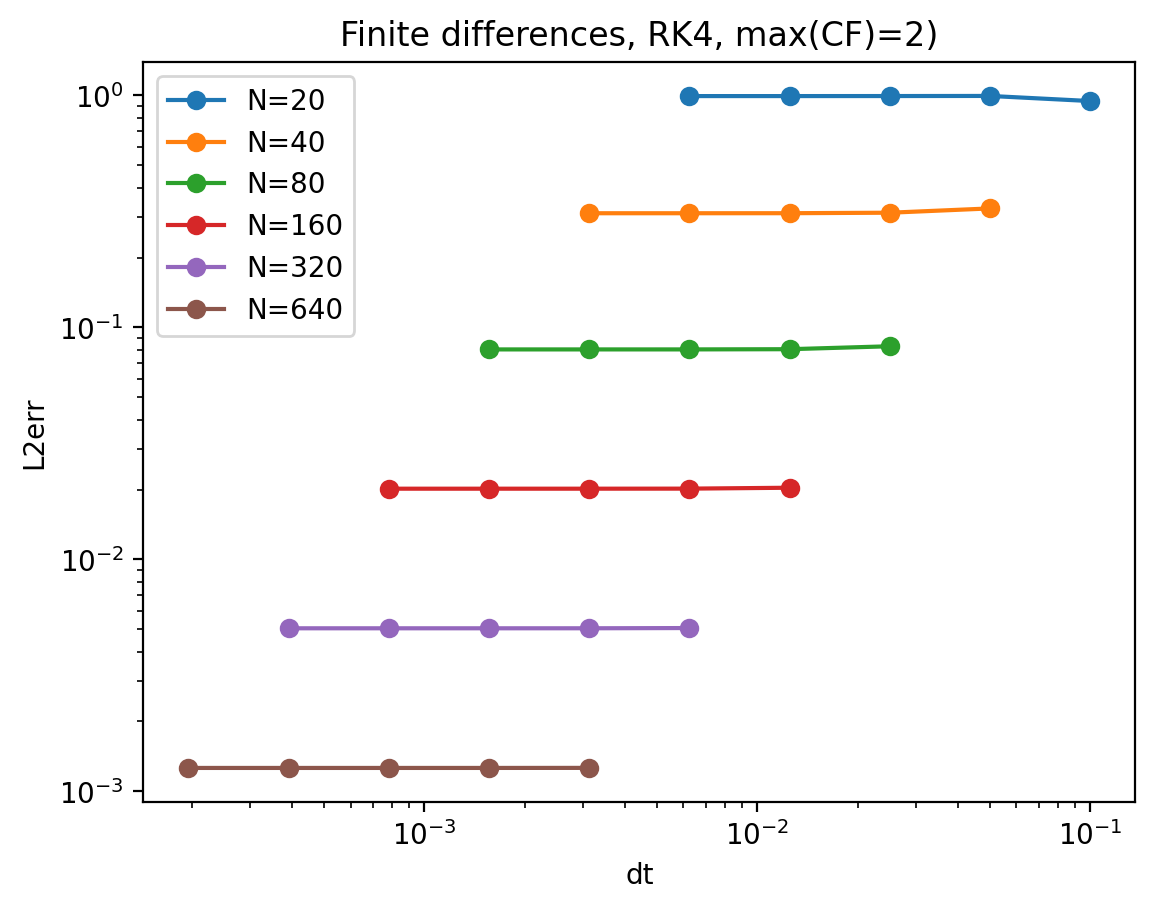

In [15]:
# convergence test - RK4

# note biggest timestep is twice that for FE and RK2, and still stable
Tfinal=1.
errN={}  # error at fixed N  vs. CF
for N in [20, 40, 80, 160, 320, 640]:
    errN[N]=[[], []]
    for CF in [2., 1., 1/2**1, 1/2**2, 1/2**3]: #, 1/2**4, 1/2**5, 1/2**6, 1/2**7]:
        t, u0, info = Setup_FD(N)
        t,u=Evolve(t, Tfinal, u0, RHS_FD, RK4_Step, CF, info)
        # L2-norm of error after advecting once through domain
        err=np.sqrt(np.dot(u-u0, u-u0)/N)
        errN[N][0].append(CF*info.dxmin)  # store time-step
        errN[N][1].append(err)            # store error
    plt.loglog(errN[N][0], errN[N][1], 'o-', label="N={}".format(N) # , basey=2., basex=10
               )  # plot!
plt.xlabel('dt'); plt.ylabel('L2err'); plt.title("Finite differences, RK4, max(CF)=2)")
plt.legend();

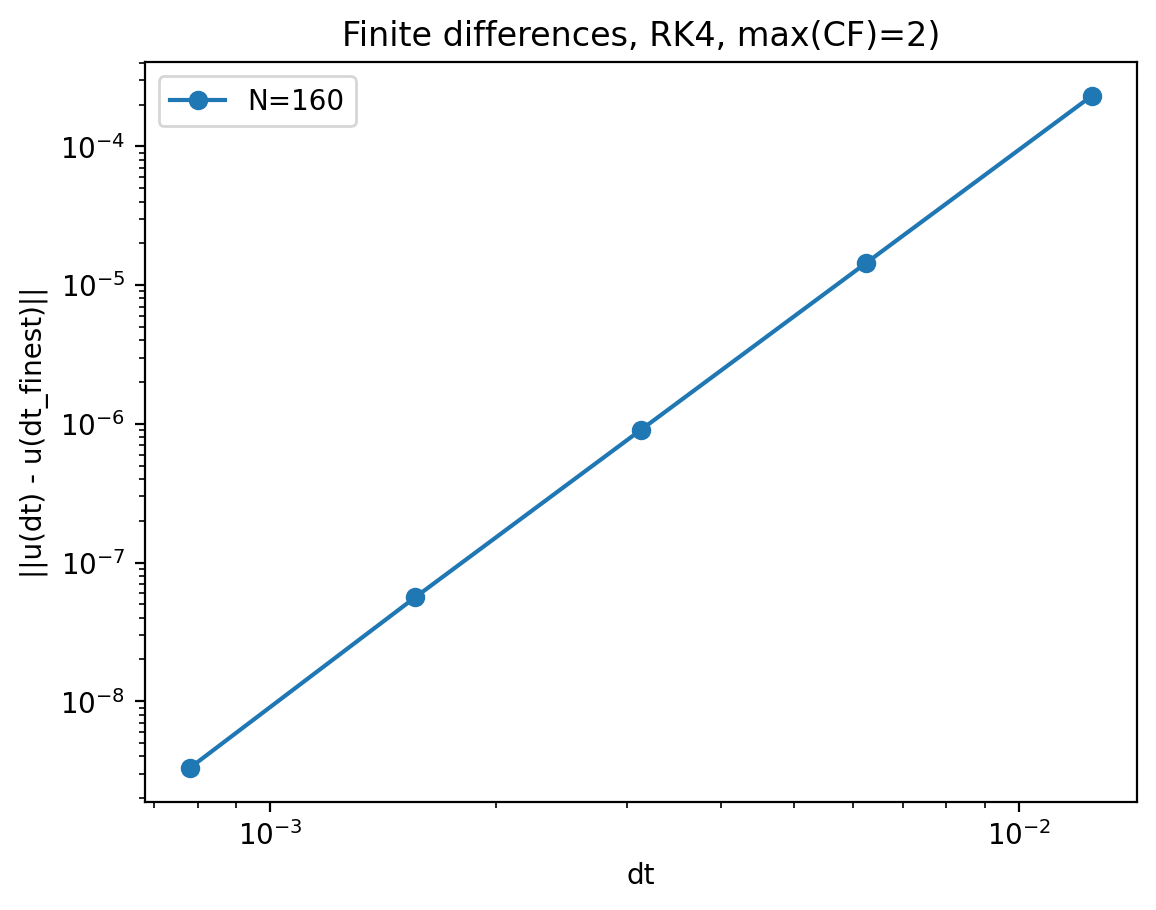

In [19]:
# convergence test 
# exhibit time-stepping error of RK4, by subtracting a *numerical*
# reference solution with same N, computed at especially small dt.
Tfinal=1.
errN={}  # error at fixed N  vs. CF
for N in [160,]:
    errN[N]=[[], []]
    # compute reference solution at very small dt:
    t, u0, info = Setup_FD(N)
    t,uref=Evolve(t, Tfinal, u0, RHS_FD, RK4_Step, 1/2**4, info)
    
    for CF in [2., 1., 1/2**1, 1/2**2, 1/2**3]: #, 1/2**4, 1/2**5, 1/2**6, 1/2**7]:
        t, u0, info = Setup_FD(N)
        t,u=Evolve(t, Tfinal, u0, RHS_FD, RK4_Step, CF, info)
        # L2-norm of error after advecting once through domain
        err=np.sqrt(np.dot(u-uref, u-uref)/N)
        errN[N][0].append(CF*info.dxmin)  # store time-step
        errN[N][1].append(err)            # store error
    plt.loglog(errN[N][0], errN[N][1], 'o-', label="N={}".format(N))
plt.xlabel('dt'); plt.ylabel('||u(dt) - u(dt_finest)||'); plt.title("Finite differences, RK4, max(CF)=2)")
plt.legend();

# Pseudo-Spectral PDE solving

In [21]:
# task PS-1
def SpectralCoefficients(u):
    """Given data u, at uniformly distributed grid-points
    0<=x<1,  perform a decomposition into a spectral series
    returns complex array A, such that
      A[0] = real = **two** times average of data
      A[k].real * cos(2 pi k x) + A[k].imag * sin(2 pi k x)
    """
    A=np.fft.rfft(u)
    # adjust signs and magnitudes
    A = (2./len(u))*np.conj(A)
    return A 

# task PS-2
def PhysicalValues(A):
    """Given spectral coefficients A[k], reconstruct the function
   0.5*A[0] + Sum_k(  A[k].real * cos(2 pi k x)
                    + A[k].imag * sin(2 pi k x)
                   )
    """
    u = np.fft.irfft(np.conj(A))
    u = u * 0.5*len(u)
    return u

# task PS-3 
def dudx_PS(u):
    """Compute the first derivative dudx, using spectral methods.
    Assumes data is equally spaced in interval 0<=x<1 and
    periodic."""
    A=SpectralCoefficients(u)
    # multiply A[k] by -2 pi j k, where j is the imagimnary unit
    # the '2pi' arises because we chose 0<x<1 as interval
    # the '-' arises because of our convention A_k = a_k + j b_k
    k= np.linspace(0, len(A)-1, len(A))
    A *= 2*np.pi*(0-1j)*k
    # convert back tp real-space values
    dudx=PhysicalValues(A)
    return dudx

# task PS-4
def RHS_PS(t, u, info):
    """Computes the right-hand-side F(t,u) of the advection equation 
       partial_t u = F(t,u)
    with pseudo-spectral methods.  Here u is the vector of data 
    with one value per grid-point.  We assume a domain x\in [0,1[, 
    and periodic boundary conditions."""
    return -dudx_PS(u)

def Setup_PS(N):
    """Perform the necessary setup for a pseudospectral 
    evolution on 'N' grid-points. 

    returns 
        t, u, info
    where
      - t=0.  the initial time
      - u the solution at t=0 (i.e. the initial guess)
      - info a tuple containing
         - info.dxmin minimal grid-spacing
         - info.x an array of grid-points"""

    # storage for extra info
    PS_Info_t=collections.namedtuple('PS_Info_t', 'dxmin, x')
    x = np.linspace(0., 1., N, endpoint=False)
    info=PS_Info_t(dxmin=1./N, x=x)
    u = AnalyticSolution(x, 0.)
    return 0., u, info

In [24]:
def Interpolate(u, x_fine):
    """given a Fourier spectral expansion on x in [0,1[
    with data u[i] = u(x_i) supplied at the Fourier 
    collocation points x_i = i/N.
    Interpolate to given fine grid x_fine by using the
    representation 
    u(x) =  0.5*A[0] + Sum_k(  A[k].real * cos(2 pi k x)
                             + A[k].imag * sin(2 pi k x) )
                    """
    A=SpectralCoefficients(u)

    u_fine = np.zeros(x_fine.shape)
    u_fine += 0.5*A[0].real
    for k in range(1,len(A)):
        u_fine += A[k].real*np.cos(2*np.pi*k*x_fine)+ A[k].imag*np.sin(2*np.pi*k*x_fine)
    return u_fine

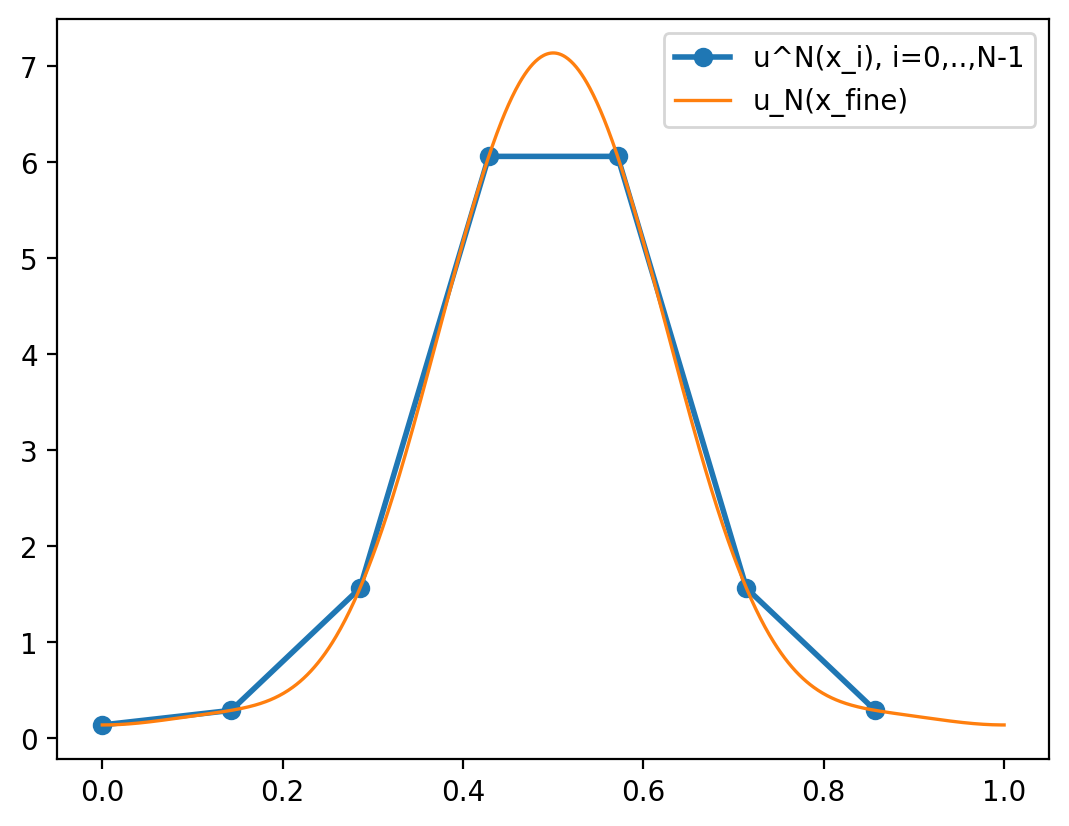

In [34]:
# test interpolaton function
t, u, info = Setup_PS(7)
x_fine=np.linspace(0,1,1000)
plt.plot(info.x, u, '-o', lw=2, label='u^N(x_i), i=0,..,N-1')
plt.plot(x_fine, Interpolate(u, x_fine), lw=1.2, label='u_N(x_fine)' )
plt.legend();

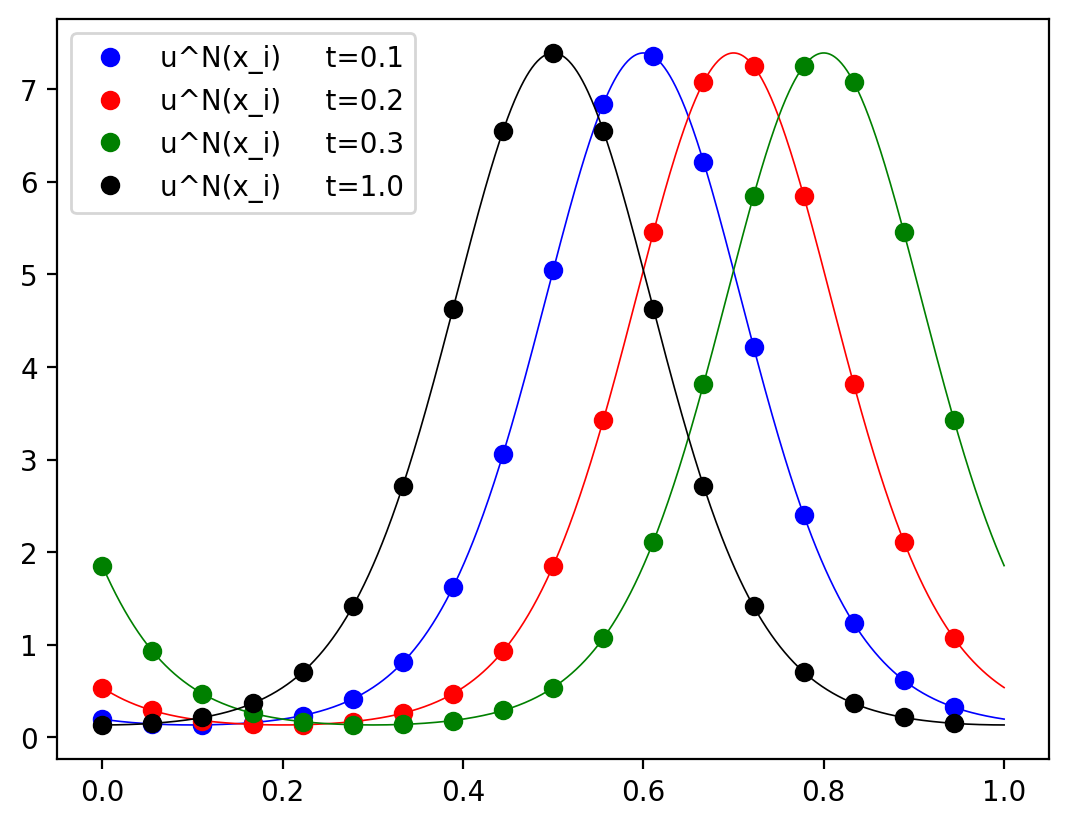

In [ ]:
t, u, info = Setup_PS(18)
for t_final,c in zip([0.1, 0.2, 0.3, 1.],['b','r','g','k']):
    t,u=Evolve(t, t_final, u, RHS_PS, RK4_Step, 1/2**3, info)
    plt.plot(info.x,u, 'o', color=c, label='u^N(x_i)     t={:3.1f}'.format(t))
    plt.plot(x_fine, Interpolate(u, x_fine), color=c, lw=.6)

plt.legend();

4
8
12
16
20
24
28
32


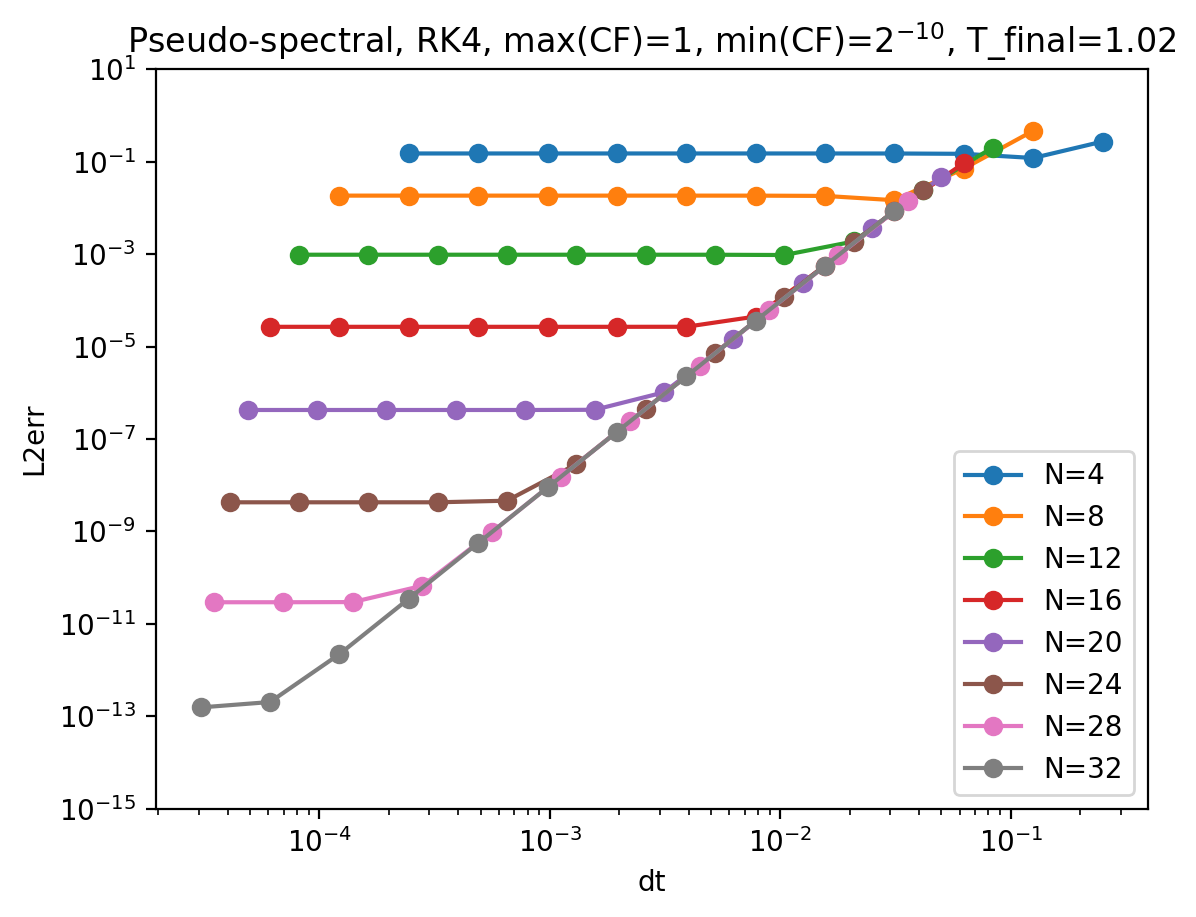

In [54]:
# convergence test - RK4
Tfinal=1.02
errN={}  # error at fixed N  vs. CF
for N in [4,8,12,16,20,24,28,32]:
    print(N)
    errN[N]=[[], []]
    for CF in [1., 1/2**1, 1/2**2, 1/2**3, 1/2**4, 1/2**5, 1/2**6, 1/2**7, 1/2**8, 1/2**9, 1/2**10]:
        t, u0, info = Setup_PS(N)
        t,u=Evolve(t, Tfinal, u0, RHS_PS, RK4_Step, CF, info)
        # L2-norm of error after advecting once through domain
        uf=AnalyticSolution(Tfinal, info.x)
        err=np.sqrt(np.dot(u-uf, u-uf)/N)
        errN[N][0].append(CF*info.dxmin)  # store time-step
        errN[N][1].append(err)            # store error
    plt.loglog(errN[N][0], errN[N][1], 'o-', label="N={}".format(N))  # plot!
plt.xlabel('dt'); plt.ylabel('L2err'); 
plt.title("Pseudo-spectral, RK4, max(CF)=1, min(CF)=$2^{{-10}}$, T_final={}".format(Tfinal))
plt.legend()
plt.ylim(1e-15, 10.);

4
8
12
16
20


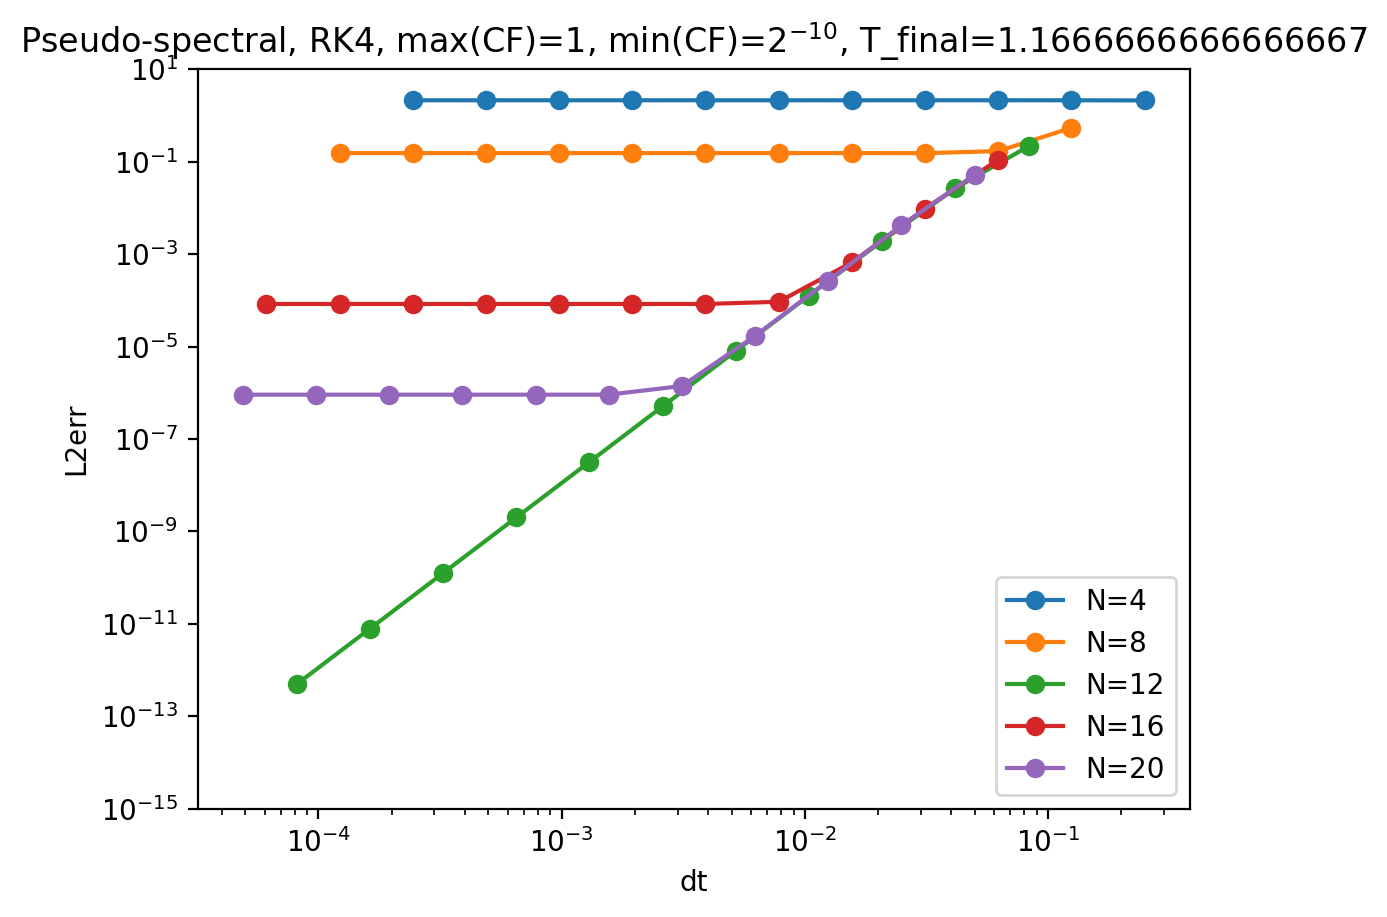

In [56]:
# EXTRA QUESTION:  Why does the convergence plot look different for different Tfinal's?

# convergence test - RK4
Tfinal=1.0
Tfinal=1+1/6
errN={}  # error at fixed N  vs. CF
for N in [4,8,12,16,20]: #,20,24,28,32]:
    print(N)
    errN[N]=[[], []]
    for CF in [1., 1/2**1, 1/2**2, 1/2**3, 1/2**4, 1/2**5, 1/2**6, 1/2**7, 1/2**8, 1/2**9, 1/2**10]:
        t, u0, info = Setup_PS(N)
        t,u=Evolve(t, Tfinal, u0, RHS_PS, RK4_Step, CF, info)
        # L2-norm of error after advecting once through domain
        uf=AnalyticSolution(Tfinal, info.x)
        err=np.sqrt(np.dot(u-uf, u-uf)/N)
        errN[N][0].append(CF*info.dxmin)  # store time-step
        errN[N][1].append(err)            # store error
    plt.loglog(errN[N][0], errN[N][1], 'o-', label="N={}".format(N))  # plot!
plt.xlabel('dt'); plt.ylabel('L2err'); 
plt.title("Pseudo-spectral, RK4, max(CF)=1, min(CF)=$2^{{-10}}$, T_final={}".format(Tfinal))
plt.legend()
plt.ylim(1e-15, 10.);

# Discontinuous Galerkin

In [57]:
def ReferenceElement(N):
    """Given the polynomial order N, initialize quantites of a reference-element
    in logical coordinate -1<=r<=1."""
    
    # Legendre polynomials are Jacobi(alpha,beta) polynomials
    alpha=0.; beta=0;

    # Gauss-Lobatto quadrature points for Legendre polynomials
    # According to Hesthaven+Warburton (p. 448, JacobGL.m) these
    # are the order N-2 Gauss quadrature points of Jacobi polynomials
    # with different alpha, beta, enlarged by end-points -1, +1. 
    #
    # note len(r)=N+1, i.e. matrices defined below (V, Vr, etc) are square
    if(N==1):
        r=np.array([-1.,1.])
    else:
        # (N-2)-th order quadrature points are roots of (N-1)-st Jacobi polynomial
        inner_roots, inner_weights = scipy.special.roots_jacobi(N-1, alpha+1, beta+1)
        r = np.concatenate([ [-1.], inner_roots, [1.] ])

    # Vandermonde matrix for Legendre polynomials
    # V[i,j] = P_j(r_i),  j=0,...,N,  i=0,...,len(r)-1
    V = np.zeros( (len(r), N+1))
    for j in range(N+1):
        # scipy normalization determined by trial and error.  
        # For **LAGRANGE POLY** ONLY, not general alpha, beta.
        # This makes the returned polynomials orthonormal
        normalization = np.sqrt((1.+2.*j)/2.)
        V[:,j] = scipy.special.eval_jacobi(j, alpha, beta, r)*normalization
        # or V[:,j] = scipy.special.legendre(j)(r)

        # check normalization
        # tmp_r, tmp_w = scipy.special.roots_jacobi(j+1, alpha, beta)
        # tmp_L=scipy.special.eval_jacobi(j, alpha, beta, tmp_r)*normalization
        # L_dot_L = sum(tmp_w*tmp_L*tmp_L)
        # print("j={}, (L,L)={}".format(j, L_dot_L))

    
    Vinv=np.linalg.inv(V)
        
    # derivatives of Legendre polynomials, evaluated at quadrature points
    # Vr[i,j] = dP_j/dr(r_i),  j=0,...,N,  i=0,...,len(r)-1
    #   use dP_j/dr = sqrt(j(j+1)) J^{alpha+1,beta+1}_{j-1}  (H+W, Eq A2)
    #   
    Vr = np.zeros( (len(r), N+1))
    for j in range(1,N+1):
        # scipy normalization determined by trial and error.  
        # For **LAGRANGE POLY** ONLY, not general alpha, beta.
        # This makes the returned polynomials orthonormal, conforming
        # to H+W conventions
        scipy_normalization=np.sqrt((1.+2.*j)*(j+1.)/(8.*j))
        normed_J = scipy.special.jacobi(j-1, alpha+1, beta+1)(r)*scipy_normalization
        Vr[:,j] = np.sqrt(j*(j+alpha+beta+1.))*normed_J  # H+W Eq. A2

        # - check normalization
        # - integrate by Legendre quadrature, to explicitly show weight-function in orthogonality 
        # tmp_r, tmp_w = scipy.special.roots_jacobi(j+4, alpha, beta)
        # tmp_L=scipy.special.eval_jacobi(j-1, alpha+1, beta+1, tmp_r)*scipy_normalization
        # - evaluate orthogonality; note weight function (1-r)(1+r)
        # L_dot_L = sum(tmp_w*tmp_L*tmp_L*(1-tmp_r)*(1+tmp_r))
        # print("j={}, (L,L)={}".format(j, L_dot_L))

    
    # derivatives of Lagrange interpolating polynomials 
    #    Dr(i,j) = dl_j/dr(r=r_i), 
    # where  l_j(r_i) = delta_{ij}
    # compute using P_j(r) = V[i,j]*l_i(r) =>  V[i,j] dl_i/dr = dP_j/dr     (*)
    #     => V^{-T} V^T[j,i] dl_i/dr = V^{-T} dP_j/dr 
    Dr = np.matmul(Vr,Vinv)
    
    # inverse of mass-matrix
    # Using (*), one can show  M = (V V^T)^(-1)
    # Turns out that the inverse of M is used in the DG algorithm,
    # and so we can directly compute M-inverse, without computing
    # matrix-inverses:
    Minv = np.matmul(V, V.transpose())
    
    # finally, M^{-1}S = Dr, and since we need S only multiplied by M^{-1},
    # we can just return Dr
    MinvS=Dr
    
    return r, Minv, MinvS

In [58]:
# replicate Hesthaven + Warburton, Fig. 3.4
r, Minv, MinvS=ReferenceElement(4)
np.set_printoptions(formatter={'float': lambda x: "{0: 0.3f}".format(x)})
print(MinvS)

[[-5.000  6.757 -2.667  1.410 -0.500]
 [-1.241  0.000  1.746 -0.764  0.259]
 [ 0.375 -1.337 -0.000  1.337 -0.375]
 [-0.259  0.764 -1.746 -0.000  1.241]
 [ 0.500 -1.410  2.667 -6.757  5.000]]


In [59]:
def Advect_Info_DG(K, N, xmin, xmax, alpha):
    """collects all info needed to evaluate the DG rhs for the Advection problem.
    Input parameters:
      K    - number of elements
      N    - polynomial order
      xmin,xmax - overall interval
      alpha - coefficient in DG flux

    Returns namedtuple with the following entries
      N     - polynomial order
      Np    - points per element
      K     - number of elements
      xmin, xmax - overall interval
      h     - width of each element
      r_ref - reference element points (i.e. r[0]=-1.  ... r[N]=+1. )
      Minv_ref, MinvS_ref -- reference element matrices
      alpha - coefficent in DG flux
      x     - total set of collocation points (for setting initial data)
      dxmin - minimal grid-spacing
      x_k   - collocation points at boundaries (for plotting) length K+1"""
    
    Np=N+1

    h=(xmax-xmin)/K
    AdvectInfo_t=collections.namedtuple('AdvectInfo_t', 
            'N, Np, K, r_ref, Minv_ref, MinvS_ref, h, xmin, xmax, alpha, x, dxmin, x_k')
    
    r, Minv, MinvS = ReferenceElement(N)
    dr=r[1:]-r[:-1]
    dxmin = min(dr)*h/2
    x_k=np.linspace(xmin, xmax, K+1)
    x=np.zeros([K*Np])
    for k in range(K):
        x[k*Np:(k+1)*Np]=xmin+k*h+h*(r+1.)/2.
    
    info=AdvectInfo_t(N=N, Np=Np, K=K, xmin=xmin, xmax=xmax, h=h, 
                    r_ref=r, Minv_ref=Minv, MinvS_ref=MinvS, alpha=alpha, 
                    x=x, dxmin=dxmin, x_k=x_k)
    return info

In [60]:
def Setup_DG(K, N, alpha):
    """Perform the necessary setup for a pseudospectral 
    evolution on 'K' domains, each with N' grid-points. 

    returns 
        t, u, info
    where
      - t=0.  the initial time
      - u the solution at t=0 (i.e. the initial guess)
      - info is described in Advect_Info_DG
      """
    info=Advect_Info_DG(K, N, 0., 1., alpha)
    u = AnalyticSolution(info.x, 0.)
    return 0., u, info

In [61]:
def AdvectRHS_DG(t, u, info):
    """Given a vector of length K*(N+1) of all grid-point values, compute the rhs of the DG advection problem"""

    periodic_BC = True
    
    # convenient variables
    N  = info.N   # highest polynomial order
    Np = info.Np  # number of points per element
    K  = info.K
    alpha = info.alpha
    
    # geometrically rescaled matrices
    MinvS = 2/info.h*info.MinvS_ref
    Minv = 2/info.h*info.Minv_ref
    
    dudt = 0.*u
    
    # compute flux on all elements
    f = u  # **right**-moving with speed 1.
    
    # volume terms
    for k in range(K):
        #print(shape(MinvS), ', ', shape(f[k*Np:(k+1)*Np]),
        #          ', ', shape(MinvS*f[k*Np:(k+1)*Np]))
                                          
        dudt[k*Np:(k+1)*Np] = -np.matmul(MinvS,f[k*Np:(k+1)*Np])  #  + g(..),  but g=0
  
    # internal boundaries
    for k in range(0,K-1):
        uminus=u[(k+1)*Np-1]
        uplus=u[(k+1)*Np]
        flux = (uminus+uplus)/2. + (1-alpha)/2.*(uminus - uplus)
        
        # insert into upper boundary of element k
        dudt[k*Np:(k+1)*Np]     += -Minv[:,N] * (flux-f[(k+1)*Np-1])
        # insert into lower bounary of element k+1
        dudt[(k+1)*Np:(k+2)*Np] +=  Minv[:,0] * (flux - f[(k+1)*Np])

    # periodic boundary conditions to connect D^0 to D^{K-1}
    # same formulae as just above, except for indexing
    if periodic_BC:
        uminus=u[K*Np-1]  # upper edge of D^{K-1}}
        uplus=u[0]        # lower edge of D^0
        flux = (uminus+uplus)/2. + (1-alpha)/2.*(uminus - uplus)

        # insert into upper boundary of element K-1
        dudt[(K-1)*Np:K*Np]     += -Minv[:,N] * (flux-f[K*Np-1])
        # insert into lower bounary of element k+1 (i.e. D^0)
        dudt[0:Np] +=  Minv[:,0] * (flux - f[0])
    else:
        raise NameError('non-period BCs not yet implemented')

    return dudt

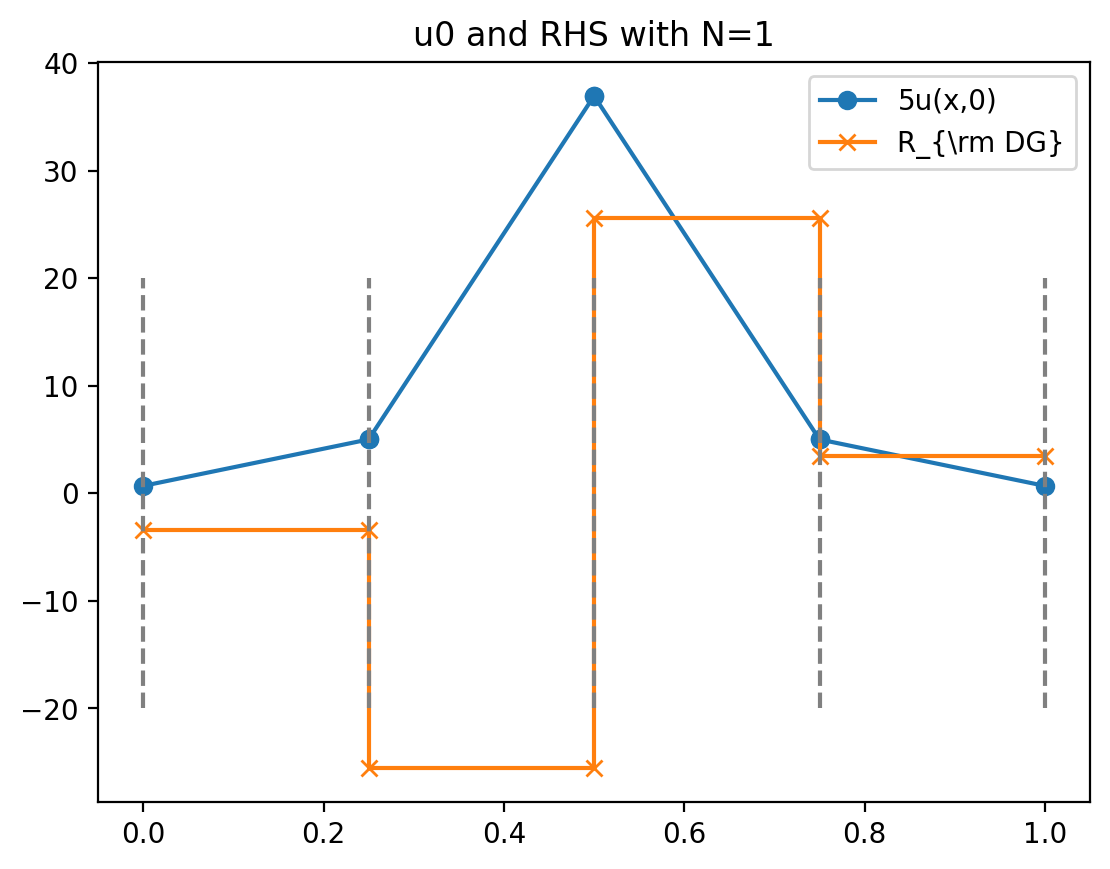

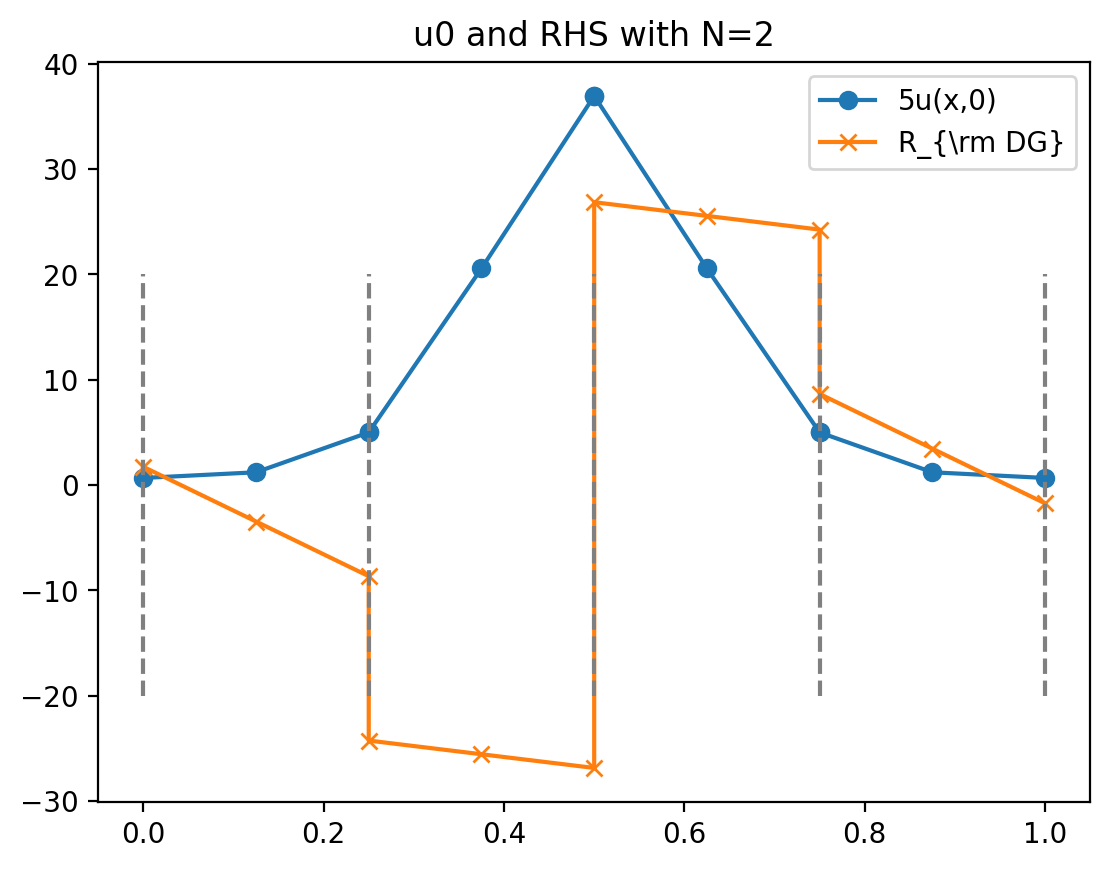

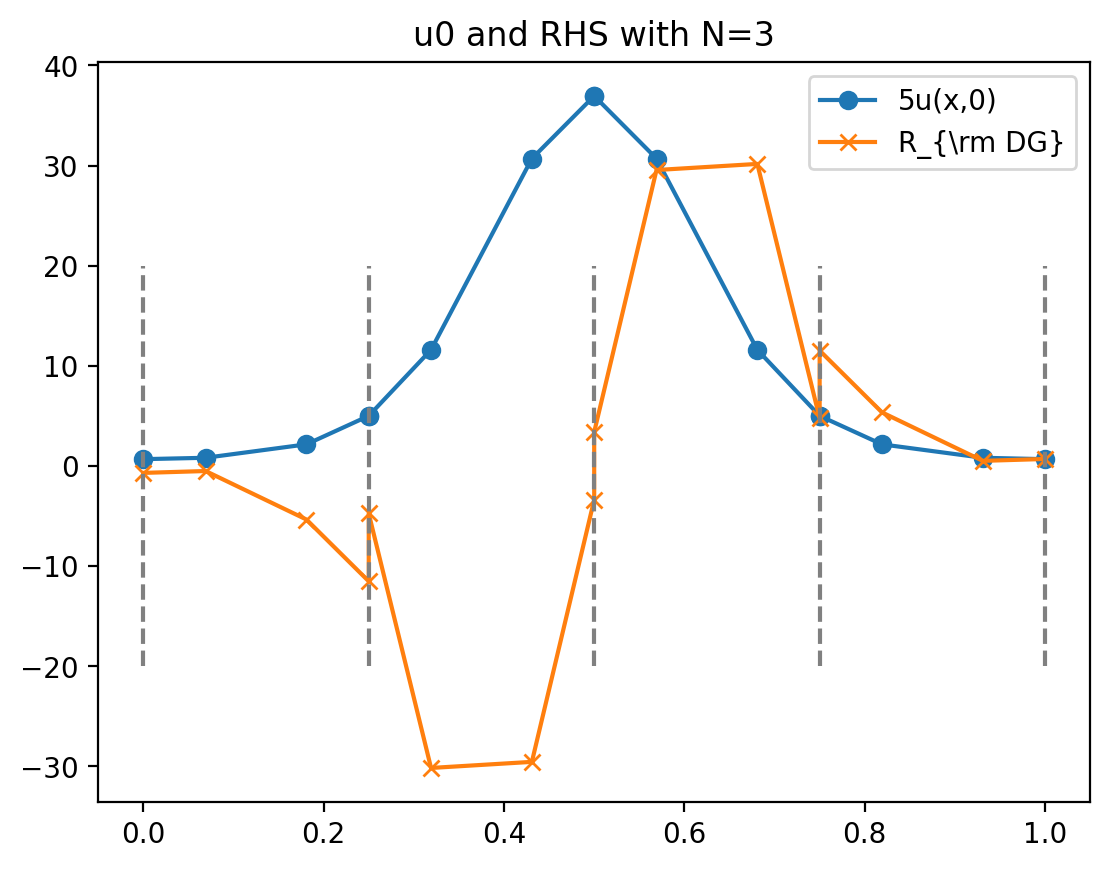

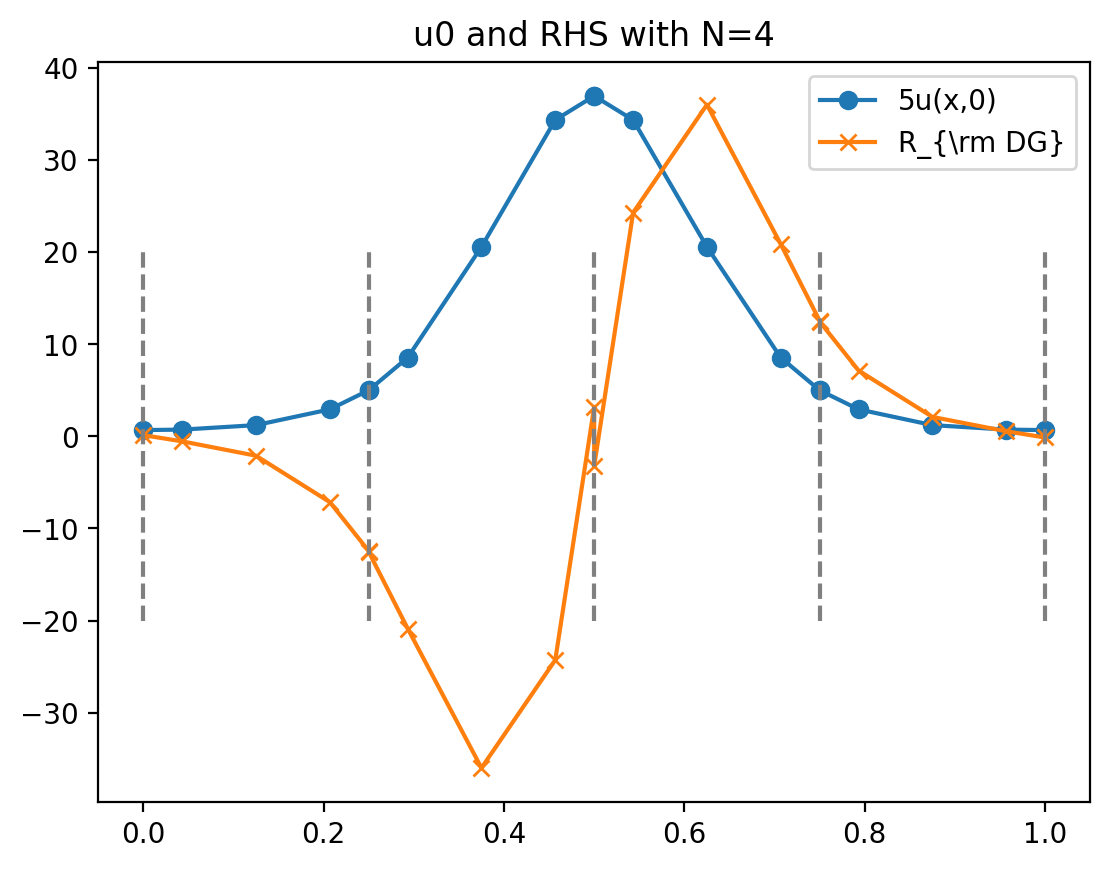

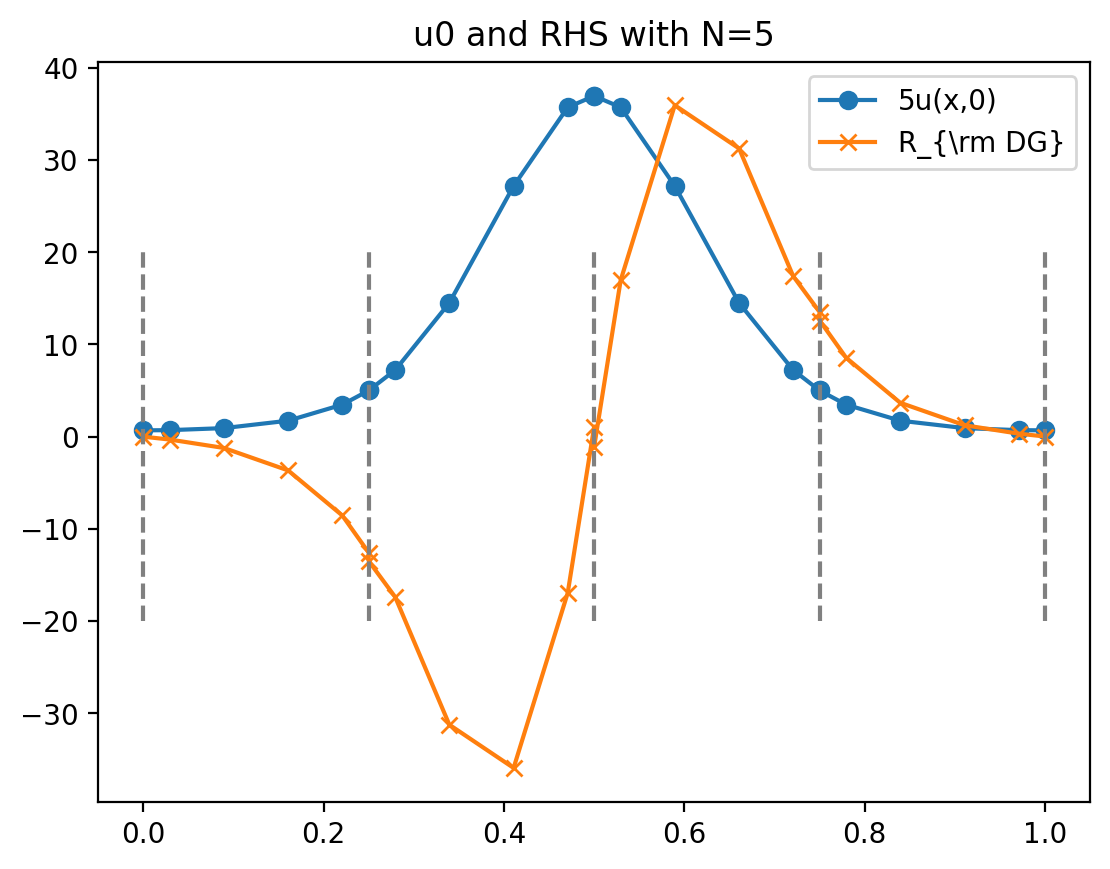

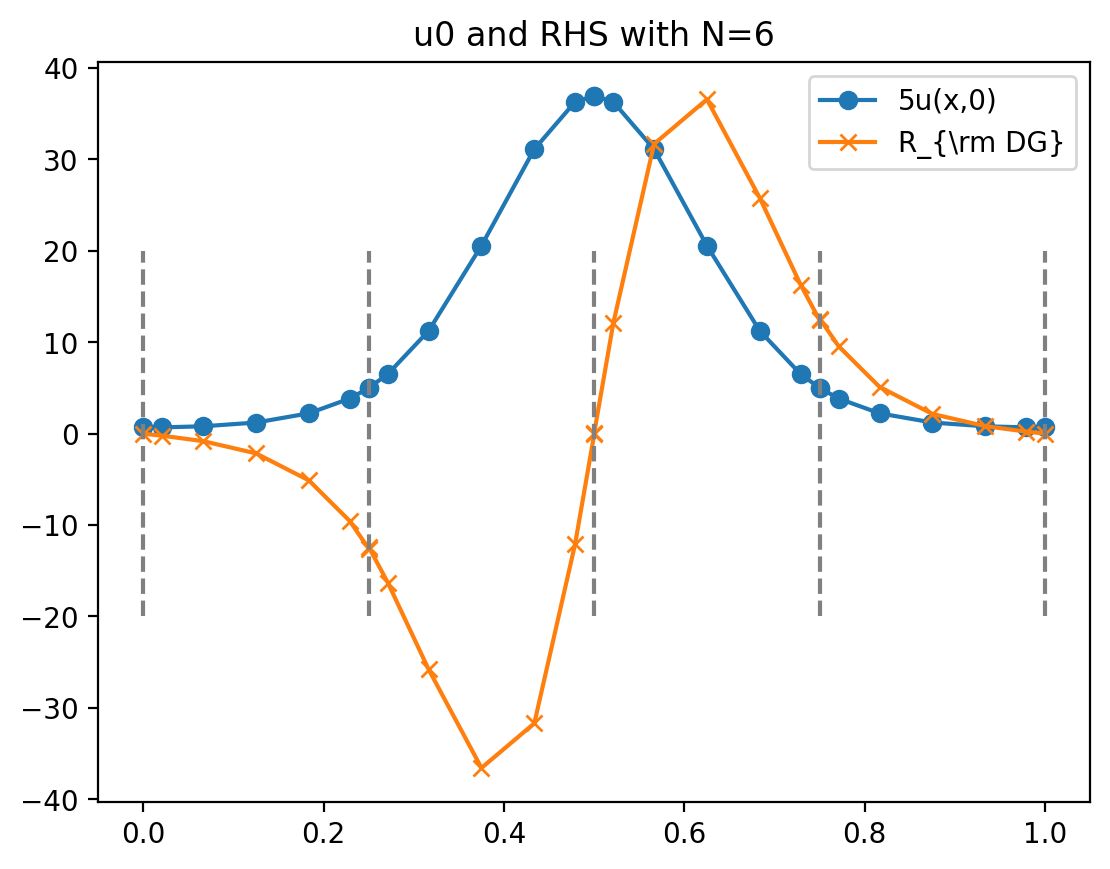

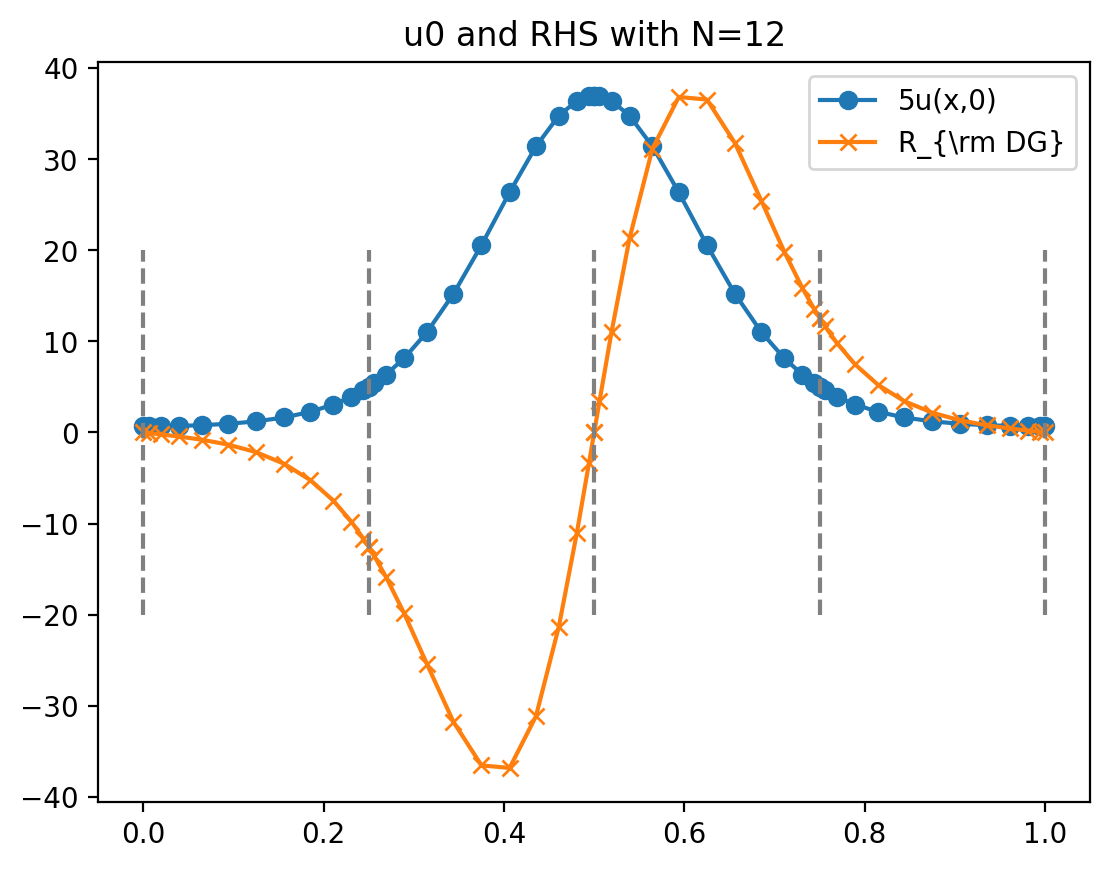

In [62]:
# plot single derivative t,u,info=Setup_DG(5,8,0.5)
for N  in [1,2,3,4,5,6,12]:
    fig=plt.figure()
    t, u, info=Setup_DG(4,N, 0.5)
    dudt=AdvectRHS_DG(t, u, info)
    plt.plot(info.x, 5*u,'-o', label='5u(x,0)')
    plt.plot(info.x, dudt, '-x', label='R_{\\rm DG}')
    for x in info.x_k: 
        plt.plot([x,x],[-20,20],'--', color='grey')
    plt.title('u0 and RHS with N={}'.format(N))
    plt.legend()
    fig.savefig('AdvectDG_RHS_K{}_N{}.png'.format(4, N))

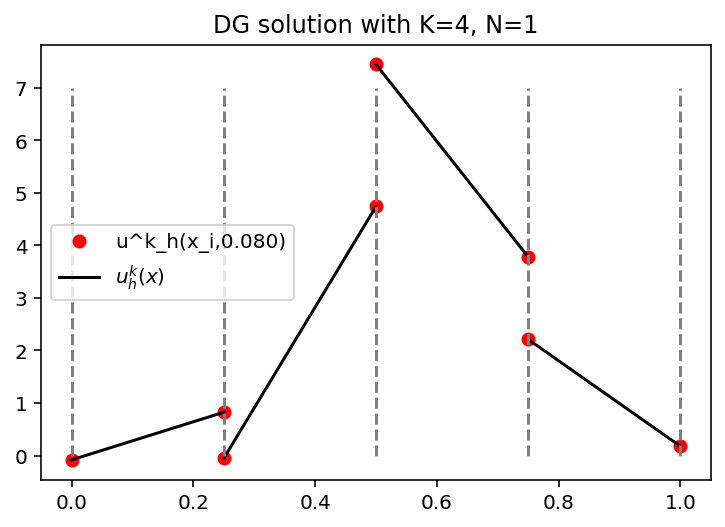

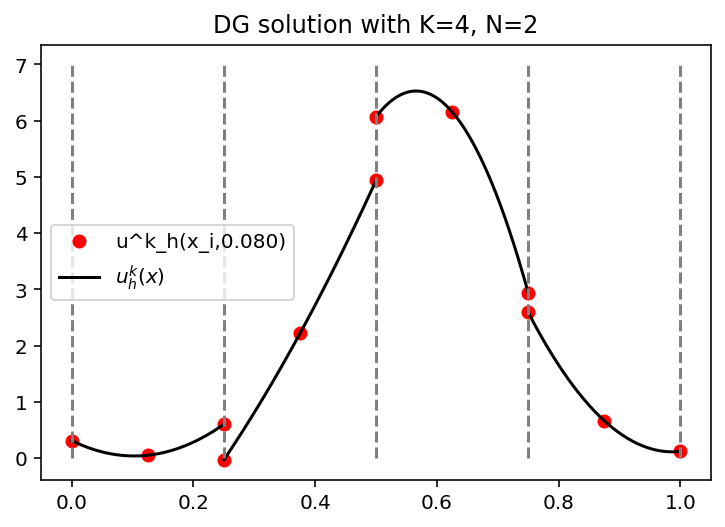

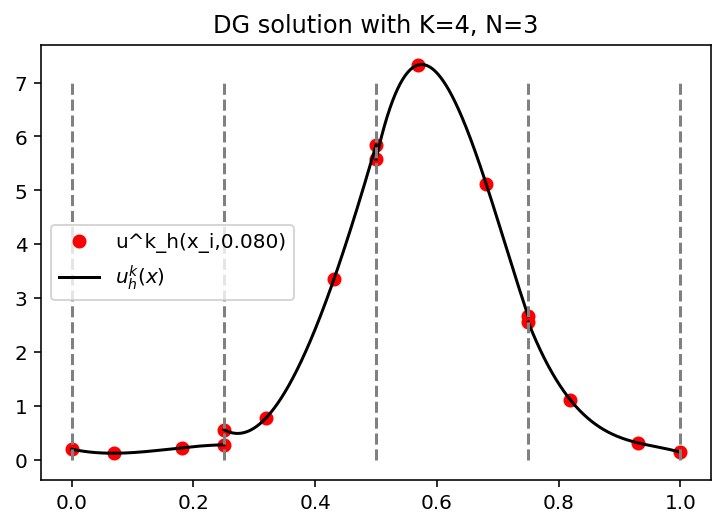

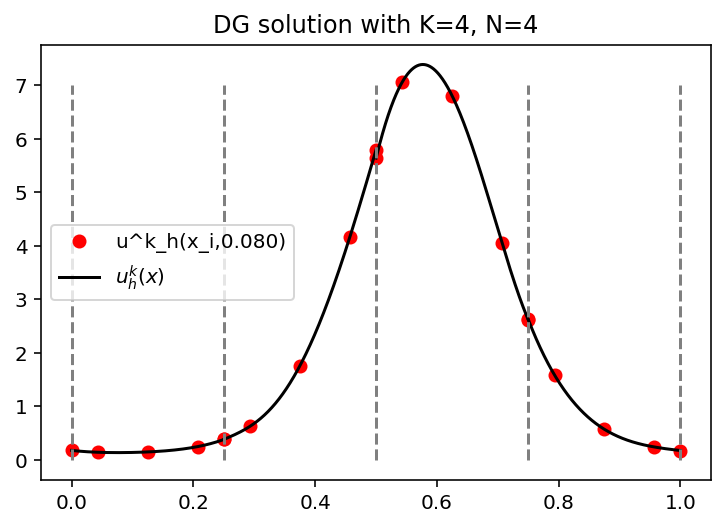

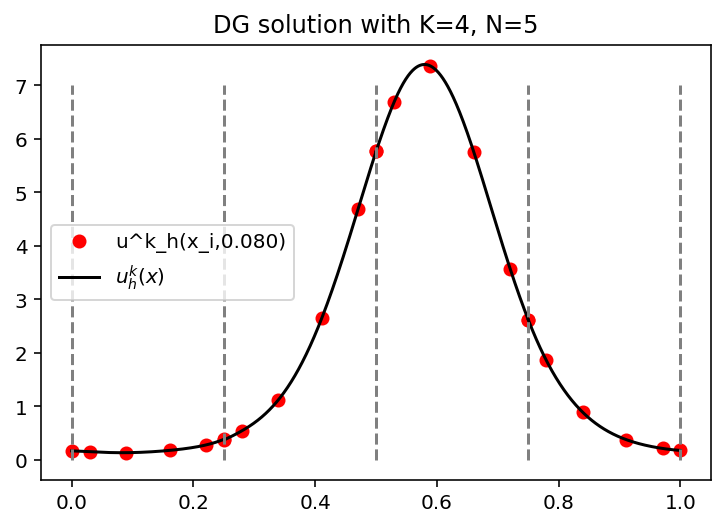

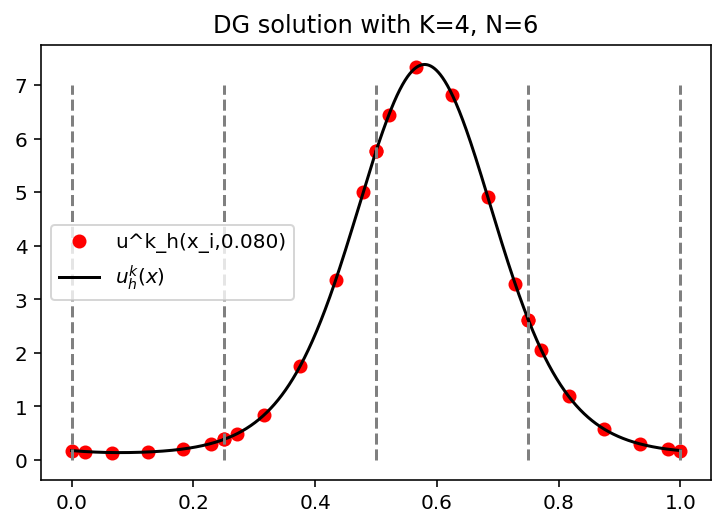

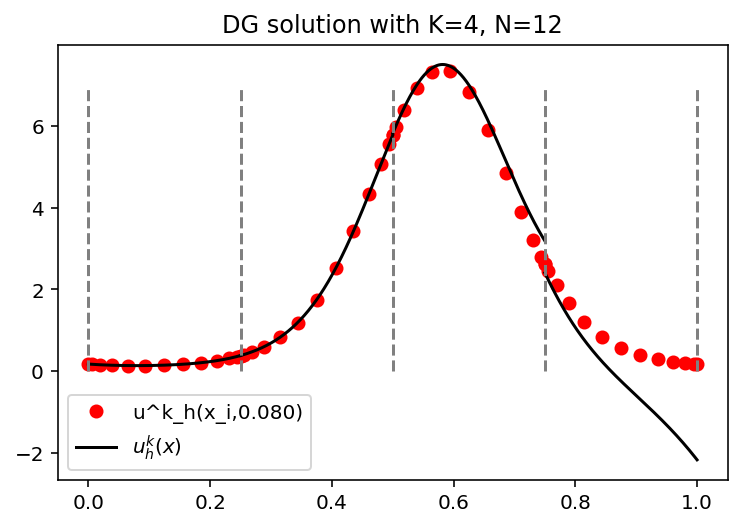

In [23]:
# evolve for a little while, then make a plot of soln
Tfinal=0.08
CF=0.01
K=4
for N  in [1,2,3,4,5,6,12]:
    fig=plt.figure()
    t, u0, info=Setup_DG(K,N, 0.5)
    Np=info.Np
    t, u = Evolve(t, Tfinal, u0, AdvectRHS_DG, RK4_Step, CF, info)
    plt.plot(info.x, u,'ro', label="u^k_h(x_i,{:4.3f})".format(t))
    for k in range(K):
        p=scipy.interpolate.lagrange(info.x[k*Np:(k+1)*Np],u[k*Np:(k+1)*Np])
        x_fine=np.linspace(info.x_k[k], info.x_k[k+1], 500)
        if(k==0):
            plt.plot(x_fine, p(x_fine), 'k-', label="$u^k_h(x)$")
        else:
            plt.plot(x_fine, p(x_fine), 'k-')

    for x in info.x_k: 
        plt.plot([x,x],[0,7],'--', color='grey')
    plt.title('DG solution with K={}, N={}'.format(K,N))
    plt.legend()

In [63]:
def ConvgTest_DG(K_choices, N_choices, CF):
    """Perform a convergence test with DG, running
    on all combination of N_choices x K_choices, and
    with Courant factor 'CF;' 
    returns
      errN dictionary, s.t. errN[N] contains err vs. K at this N"""

    # convergence test - RK4
    Tfinal=1.0

    errN={}
    for N in N_choices:
        #print(N)
        print("N={}, CF={}".format(N,CF))
        errN[N]=[[],[]]
        for K in K_choices:
            t, u0, info = Setup_DG(K,N, 0.5)
            t, u = Evolve(t, Tfinal, u0, AdvectRHS_DG, RK4_Step, CF, info)

            # L2-norm of error after advecting once through domain
            uf=AnalyticSolution(Tfinal, info.x)
            err=np.sqrt(np.dot(u-uf, u-uf)/len(u))
            if(N==1 and K<=2): 
                continue # avoid one divergent point
            errN[N][0].append(K)
            errN[N][1].append(err)
            if K>=6 and errN[N][1][-2]<err: 
                # stop if error is increasing
                break
    return errN

N=1, CF=0.0078125
N=2, CF=0.0078125
N=4, CF=0.0078125
N=6, CF=0.0078125
N=8, CF=0.0078125
N=10, CF=0.0078125
N=12, CF=0.0078125
N=1, CF=0.015625
N=2, CF=0.015625
N=4, CF=0.015625
N=6, CF=0.015625
N=8, CF=0.015625
N=10, CF=0.015625
N=12, CF=0.015625


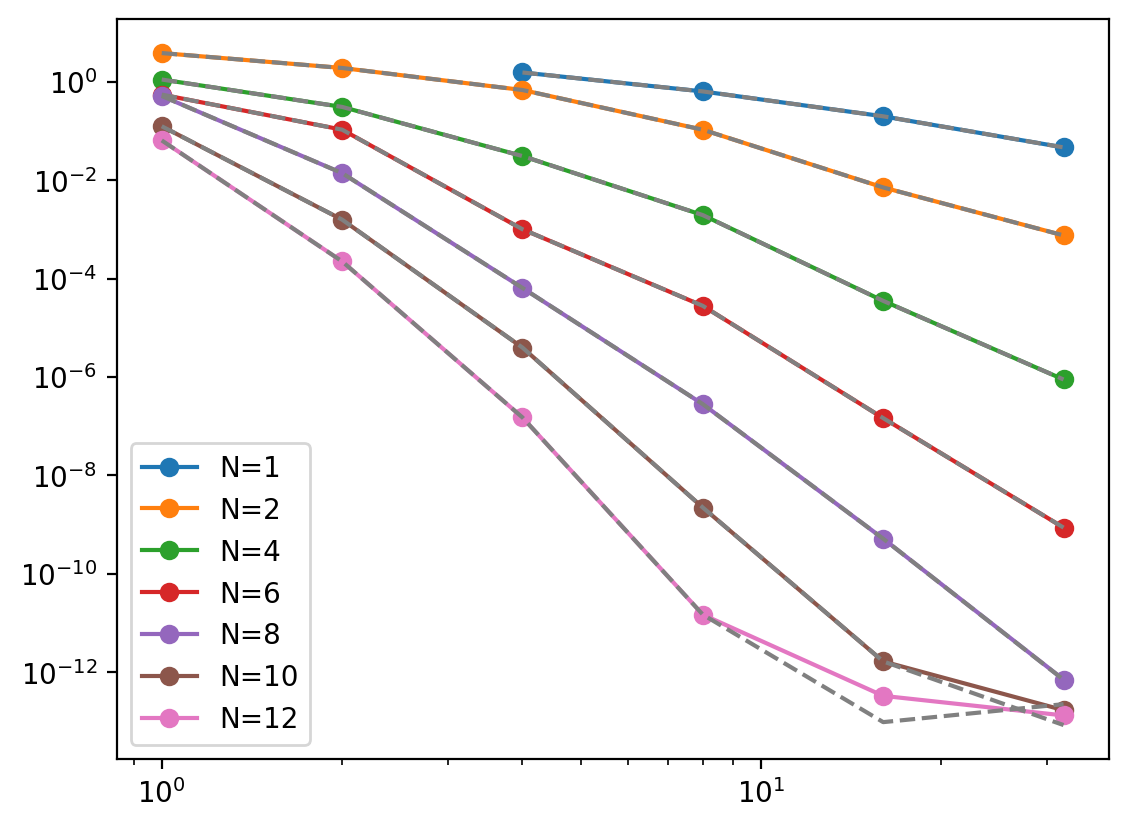

In [ ]:
# calculate data for convergence test, use two 
# different CF's to verify that time-stepping error
# is irrelevant.
# store results to be reused for multiple plots
CF1=1./2**7
CF2=CF1*2
K_choices=[1,2,4,8,16,32]
N_choices=[1,2,4,6,8,10,12]
err_C1 = ConvgTest_DG(K_choices, N_choices, CF1)
err_C2 = ConvgTest_DG(K_choices, N_choices, CF2)

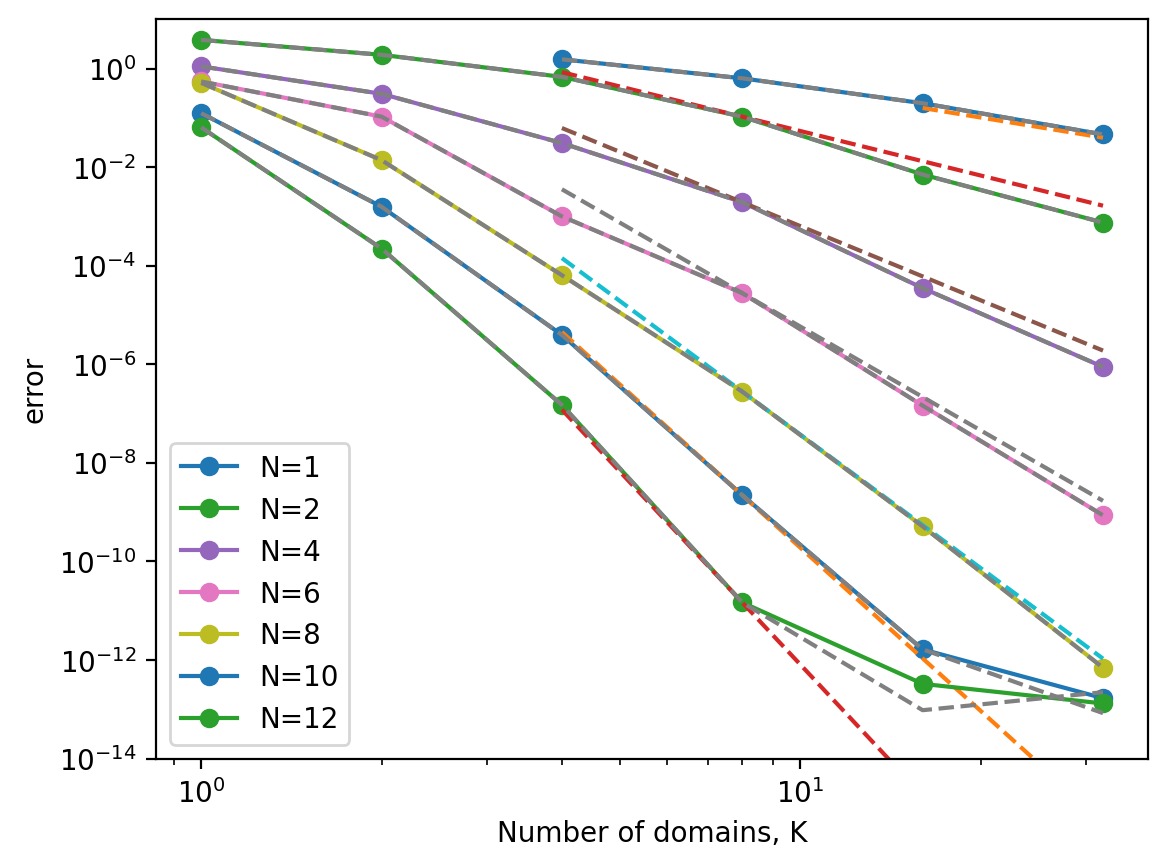

In [68]:
for N in err_C1.keys():
    k=err_C1[N][0]
    y=err_C1[N][1]
    # plot data
    plt.loglog(k,y, 
               label="N={}".format(N), 
               marker='o', linestyle='-')
    # plot expected slope, normalized by 3-rd last data-point
    plt.loglog(err_C1[N][0][2:],   
               (np.array(err_C1[N][0])[2:]/err_C1[N][0][-3])**(-N-1)*err_C1[N][1][-3],'--')

# plot higher courant-factor data to check that time-step is small enough
for N in err_C2.keys():
    plt.loglog(err_C2[N][0], err_C2[N][1],  
               linestyle='--', color='gray')

plt.ylim(1e-14,10);
plt.xlabel("Number of domains, K")
plt.ylabel('error')
plt.legend();

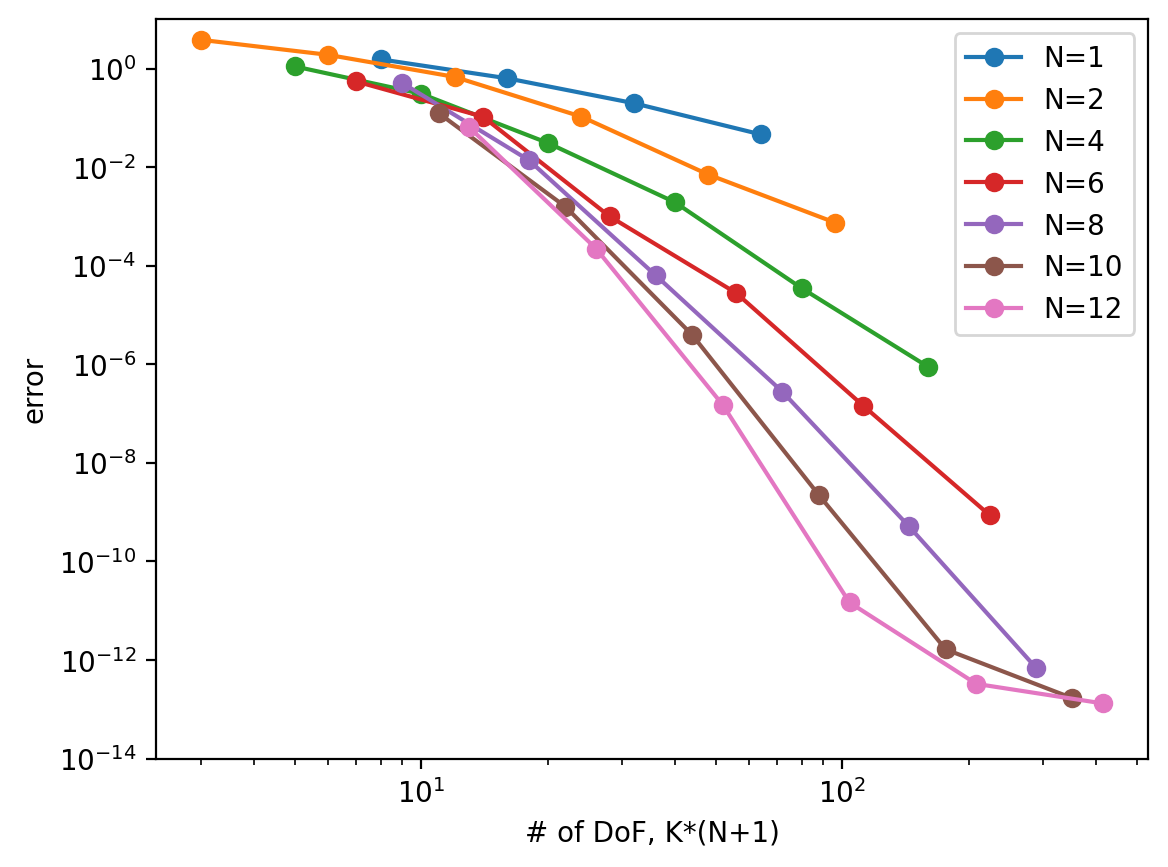

In [ ]:
for N in err_C1.keys():
    k=err_C1[N][0]
    y=err_C1[N][1]
    # plot data
    plt.loglog(np.array(k)*(N+1),y, 
               label="N={}".format(N), 
               marker='o', linestyle='-')

plt.ylim(1e-14,10);
plt.xlabel("Number of DoF = K*(N+1)")
plt.ylabel('error')
plt.legend();

Each vertical line represents the paralelisation potential.
For each vertical line: At the top K=1 element, at bottom K=32 elements
The bottom most configuration on 32 cores would run as fast
as the top one on one core, but much more accurate.


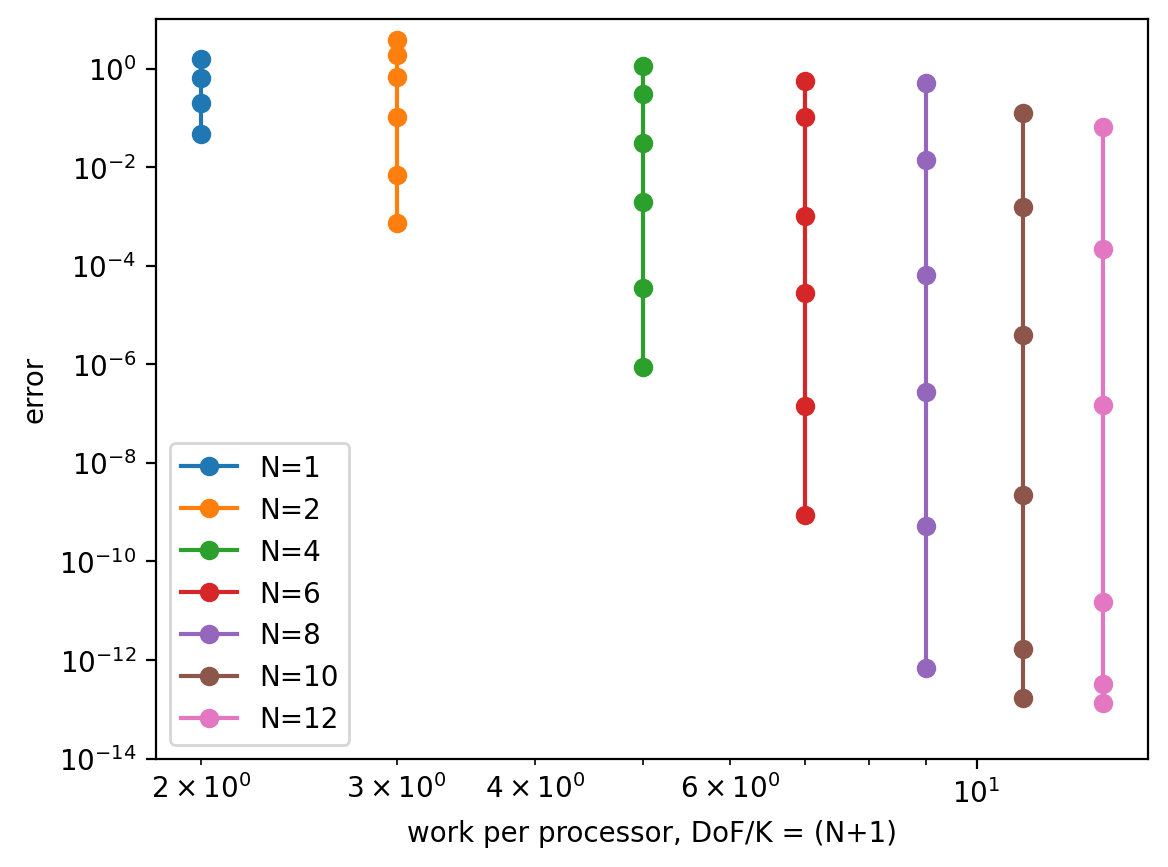

In [69]:
for N in err_C1.keys():
    k=err_C1[N][0]
    y=err_C1[N][1]
    # plot data
    plt.loglog(np.array(k)*0+(N+1),y, 
               label="N={}".format(N), 
               marker='o', linestyle='-')

plt.ylim(1e-14,10);
plt.xlabel("work per processor, DoF/K = (N+1)")
plt.ylabel('error')
plt.legend();
print("Each vertical line represents the paralelisation potential.\n"
      "For each vertical line: At the top K=1 element, at bottom K=32 elements\n"
      "The bottom most configuration on 32 cores would run as fast\n"
       "as the top one on one core, but much more accurate.")